In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing as pp
from sklearn.datasets import fetch_openml

### Load MNIST Dataset

In this notebook, we will download the **MNIST** dataset as available on the [OpenML](https://www.openml.org) platform.

To do so, we will use the `fetch_openml` utility function
included in scikit-learn.

This will download the dataset in the default `data_home`,
which is `$HOME/scikit_learn_data`.

Read more in the
[User Guide](https://scikit-learn.org/stable/datasets/index.html#openml)
on Scikit-learn Documentation

In [2]:
# We will get data directly, without any metadata for simplicity
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

IMG_SIZE = (28, 28)  # Constants for reshaping whenever will be needed

##### Descripting statistics of the dataset

In [3]:
X.shape

(70000, 784)

In [4]:
y = y.astype(int)  # in OpenML labels are encoded as strings by default
y.shape

(70000,)

Counting the number of samples per each class.

Using the `Counter` object from the `collections` package

In [5]:
from collections import Counter

counter = Counter(y)  # counting the no. samples per class

In [6]:
counter

Counter({5: 6313,
         0: 6903,
         4: 6824,
         1: 7877,
         9: 6958,
         2: 6990,
         3: 7141,
         6: 6876,
         7: 7293,
         8: 6825})

In [7]:
# Getting the top most represented classes

counter.most_common(3)

[(1, 7877), (7, 7293), (3, 7141)]

In [8]:
# Getting the least represented class

least_repr_class = min(counter, key=lambda c: counter[c])
print(f"{least_repr_class}: {counter[least_repr_class]}")

5: 6313


In [11]:
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
plt.style.use('seaborn-white')

%matplotlib inline

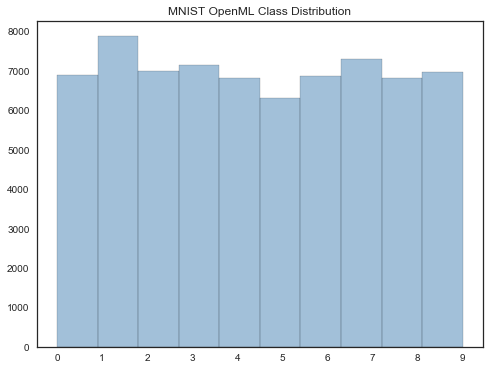

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(list(counter.elements()), bins=10, 
         facecolor='steelblue', edgecolor='k', alpha=0.5)
plt.title('MNIST OpenML Class Distribution')
plt.xticks(np.arange(10))
plt.show()

###### Note on Performance

In case your machine is struggling with the computation included in this notebook, you could 
alternatively substitute the full **real world** MNIST dataset with its "toy" version as provided by the 
`load_digits` function included in `sklearn`.

This will drastically speed-up the computation, although reducing the quality of the results. 

Here is a comparison of the two datasets:

(A) **MNIST** (`fetch_openml`): `70,000` samples, $28 \times 28$ images;

(B) **DIGITS** (`load_digits`): `1,797` samples, $8 \times 8$ each 

In [13]:
# Load digits, and compare class distributions
from sklearn.datasets import load_digits

X_small, y_small = load_digits(return_X_y=True)

print("X_small shape: ", X_small.shape)
print("y_small shape: ", y_small.shape)

X_small shape:  (1797, 64)
y_small shape:  (1797,)


In [14]:
counter_digits = Counter(y_small)

In [15]:
counter_digits

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

In [16]:
counter_digits.most_common(3)

[(3, 183), (1, 182), (5, 182)]

Let's have a look at the distribution of samples per class in the **digits** dataset:

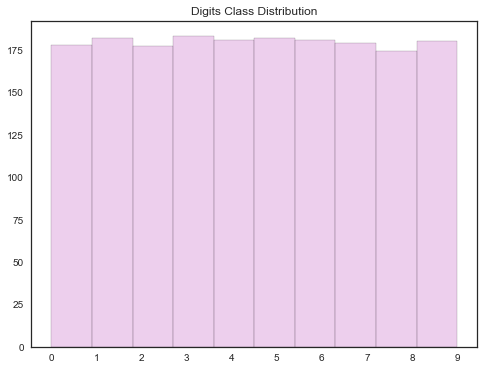

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(list(counter_digits.elements()), bins=10, 
         facecolor="plum", edgecolor="k", alpha=0.5)
plt.title('Digits Class Distribution')
plt.xticks(np.arange(10))
plt.show()

As expected, this "toy" version of the dataset contains a more balanced distribution of samples 
per class than the original dataset.

In [18]:
## UNCOMMENT the following lines to use DIGITS instead of OpenML MNIST in the rest of the notebook.
# X, y = X_small, y_small
# IMG_SIZE = (8, 8)

---

#### Dataset Partitioning

Before we proceed further on applying **dimensionality reduction** techniques on the MNIST dataset, we will partion the dataset into two _disjoint_ datasets, namely **training** and **test** sets.

To do so, we will leverage on the `train_test_split` function of `sklearn`:

In [19]:
from sklearn.model_selection import train_test_split

We will pass in input the data and the corresponding labels to partition, along with 
`test_size` ($\in [0, 1)$) indicating the percentage of samples to randomly assign to the test 
set partition. The function also accepts a `stratify` parameter, used to balance the distribution of 
samples per-classes in the two partitions. 

![train_test_split](./images/train_test_split.svg)

In [20]:
# Load the datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=7)

In [21]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (52500, 784)
Shape of y_train:  (52500,)
Shape of X_test:  (17500, 784)
Shape of y_test:  (17500,)


##### Visualising samples

Let's now visualise some samples extracted from the two partitions, along with their corresponding label.

To do so, we will write an helper function (`view(digit, dataset)`) that shows samples 
of specified digits as randomly extracted from a target dataset partition, i.e. a (`X`, `y`) pair.

In [22]:
def generate_samples(digit, partition, seed=7):
    """Generate samples of target digit class, randomly extracted from target partition
    
    Parameters
    ----------
    digit: int
        The target MNIST digit class of samples.
    partition: tuple
        A (X, y) pair corresponding to target data partition
    seed: int (default 7)
        The random seed to use for samples shuffling
    
    Yields
    ------
    int
        sample index
    int
        sample label (will correspond to digit)
    numpy.ndarray
        sample image, already reshaped according to IMG_SIZE
    """
    X, y = partition
    samples_indices = np.where(y == digit)[0]
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(samples_indices)  # Shuffle indices
    for idx in samples_indices:
        label = y[idx]
        image = X[idx,:].reshape(IMG_SIZE)
        yield idx, label, image
    
from mpl_toolkits.axes_grid1 import ImageGrid

def view(digit, dataset="training", grid_size=(3, 3)):
    if dataset == "training":
        partition = (X_train, y_train)
    else:
        partition = (X_test, y_test)

    fig = plt.figure(figsize=(8., 8.))
    plt.suptitle(f"Samples from {dataset} partition for digit {digit}")
    grid = ImageGrid(fig, 111,
                     nrows_ncols=grid_size,  
                     axes_pad=0.3,  # pad between axes in inch.
                     )
    
    samples = generate_samples(digit, partition)
    len_samples = grid_size[0] * grid_size[1]
    for ax, im in zip(grid, range(len_samples)):
        # Iterating over the grid returns the Axes.
        idx, label, im = next(samples)
        ax.set_title(f"Example: {idx}  Label: {label}")
        ax.imshow(im)
        
    plt.axis('off')
    plt.show()

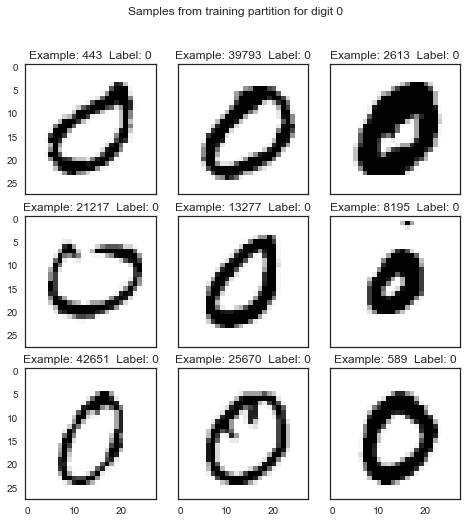

In [23]:
view(0)

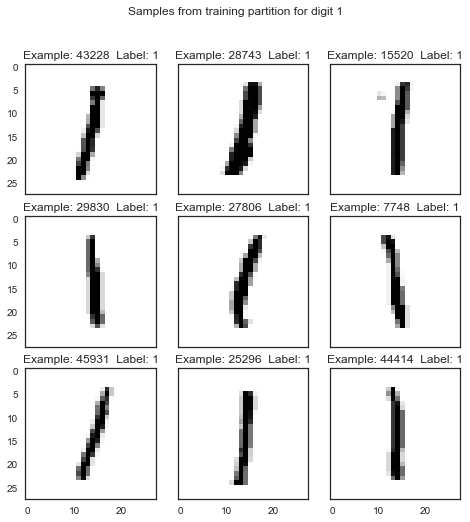

In [24]:
view(1)

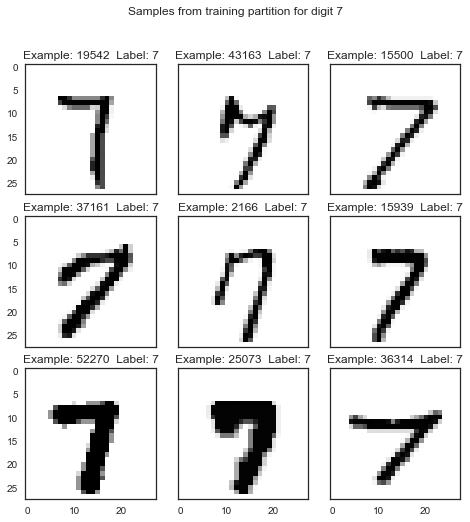

In [25]:
view(7)

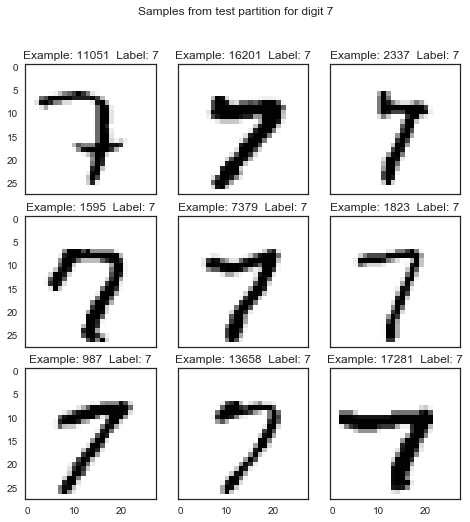

In [26]:
view(7, "test")

### Dimensionality Reduction on MNIST dataset

##### Principal Component Analysis

In [27]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 7

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)

In [28]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 784 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999999999997


In [29]:
pca_explained_var = pca.explained_variance_ratio_

In [30]:
for no_comps in (10, 20, 50, 100, 200, 300):
    print(f"Variance Captured by the first {no_comps} Principal Components: ", 
          pca_explained_var[:no_comps].sum())

Variance Captured by the first 10 Principal Components:  0.4895486979378904
Variance Captured by the first 20 Principal Components:  0.6449423532133545
Variance Captured by the first 50 Principal Components:  0.8256909504222977
Variance Captured by the first 100 Principal Components:  0.9150751298376102
Variance Captured by the first 200 Principal Components:  0.9665909688528757
Variance Captured by the first 300 Principal Components:  0.9863018965221538


In [35]:
def scatter_plot(X_trans, y, method_name):
    trans_df = pd.DataFrame(data={"First Component": X_trans[:, 0],
                                  "Second Component": X_trans[:, 1], 
                                  "Label": y})
    sns.lmplot(x="First Component", y="Second Component", 
               hue="Label", data=trans_df, fit_reg=False, 
               height=10, palette="colorblind")
    ax = plt.gca()
    ax.set_title(f"Separation of Observations using {method_name}")
    plt.show()

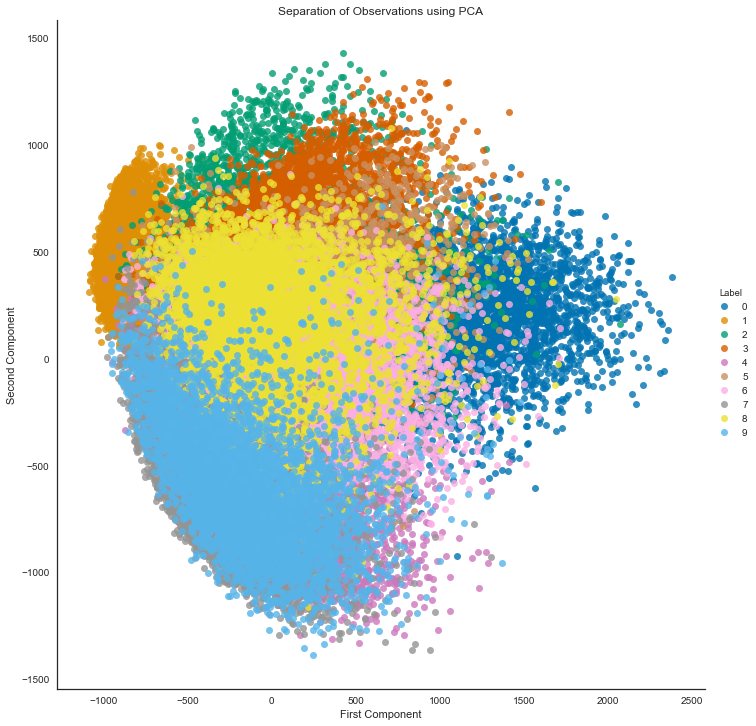

In [36]:
scatter_plot(X_train_PCA, y_train, "PCA")

###### Original Feature Set

As a comparison, let's draw how samples are separated in the original feature set, by simply considering the two features corresponding to the highest variance

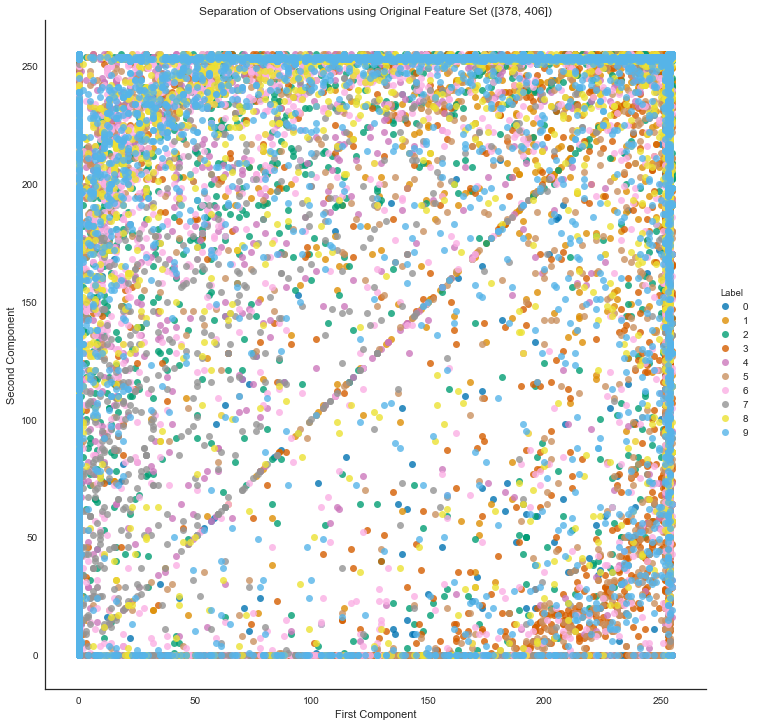

In [37]:
top_var_features = X_train[:, ].var(axis=0).argsort()[::-1][:2]
X_orig = X_train[:, top_var_features]
scatter_plot(X_orig, y_train, f"Original Feature Set ({top_var_features.tolist()})")

##### Multi dimensional Scaling

In [34]:
# Multidimensional Scaling
from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 7

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, \
          metric=metric, n_jobs=n_jobs, random_state=random_state)

# for the sake of performance, 
# let's limit MDS computation to the first batch of 1,000 samples 
X_train_mds = mds.fit_transform(X_train[:1000,:])

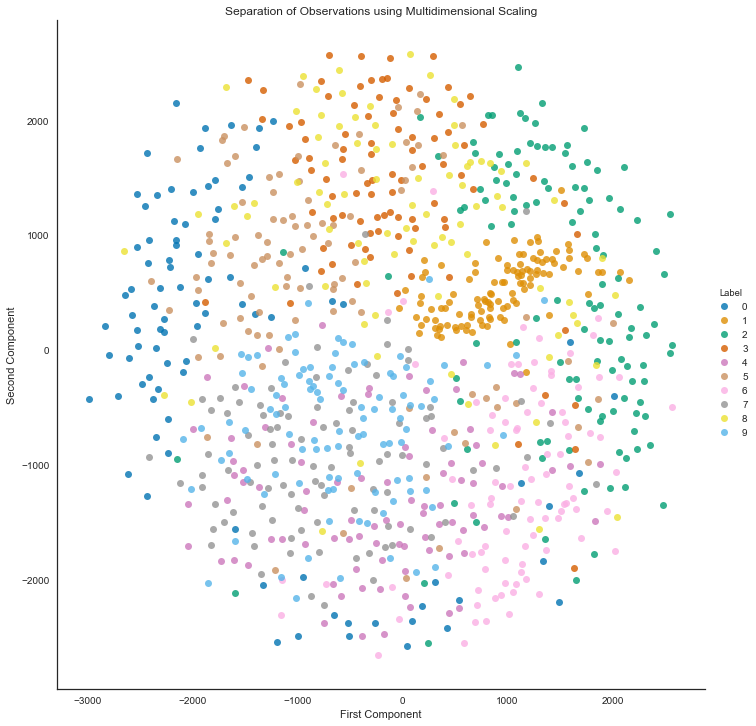

In [38]:
scatter_plot(X_train_mds, y_train[:1000], "Multidimensional Scaling")

##### t-distributed Stochastic Neighbor Embedding

In [40]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 7

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
            perplexity=perplexity, early_exaggeration=early_exaggeration, \
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA[:5000,:9])

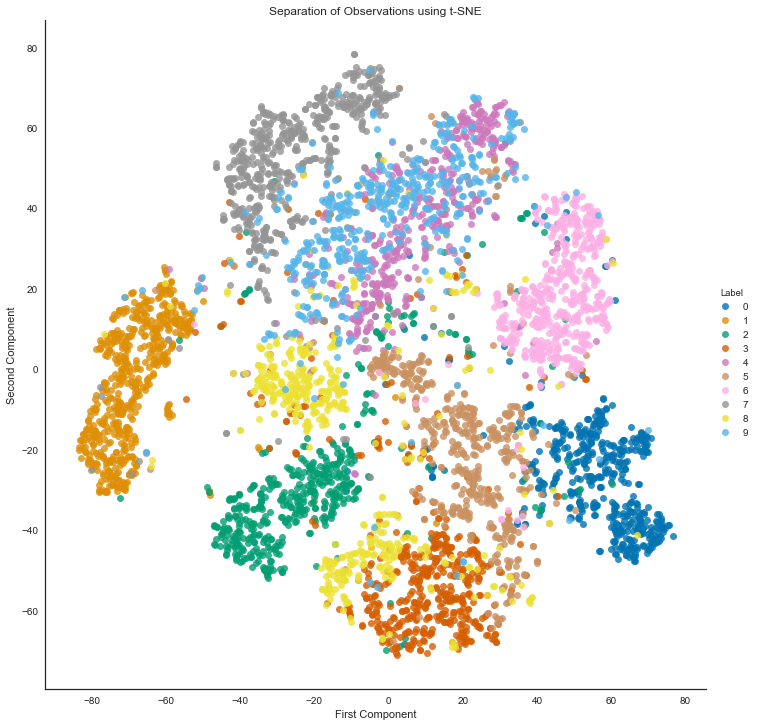

In [41]:
scatter_plot(X_train_tSNE, y_train[:5000], "t-SNE")